# Persistence against Noise and Decreasing Competency
Schedules to accelerate the aging process:
- Reducing the __Competency level__ over time via scheduling the _decision-making probability_: actions suggested by agents are forwarded to the environment with probability $P$, i.e., every time-step when a random number $r<P$ an Agent's proposed action is forwarded, otherwise it is rejected and a default action (usually all zeros) is applied. We can vary $P(t)$ starting e.g. from $P(0)=1\rightarrow P(N)=0$ over the lifetime of an individual, where $N$ is a maximum step number. At a finite noise-level (see below), this will eventually lead to the "death" of an individual (random cell types).
- Increasing the __Noise Level__  over time via scheduling the _noise_ for `type` and `hidden` cell state entries: each cell state consists of numerical values of three `type` and one `hidden` channels; this is what an Agent tries to update at each time step. Moreover, we add noise to each of these numbers at each time step with a certain `noise` level, irrespective of the above decision making probability $P$. Thus, scaling the `noise` from zero to large values over the lifetime of an individual will eventually lead to the death of an individual.
- Changing (mutating) the __ANN Parameters__ of the neural network based Agents over time by adding Gaussian noise to the ANN parameters (for the current implementation, this is done the same for all agents in an individual). This will eventually lead to random ANN parameters through parameter diffusion and thus can lead to cell "death".
- Reliable __Cell–Cell Communication__ between agents is essential for decentralized collective decision-making. Similar to biological tissues, cells in a Neural Cellular Automaton (NCA) form a lattice of functionally homogeneous units whose coordination with fixed neighbors allows collective behavior. To simulate age-related communication loss, we progressively block communication channels (gap junctions, GJs) between neighboring cells over time by setting the input state $c_{ij}=0$ for blocked connections. The probability $P_{GJ}(t_k)$ defines the fraction of open GJs at time $t_k$, linearly decreasing from $P_{GJ}(0)=1$ to $P_{GJ}(t_A=1000)=0$, thereby isolating cells from their tissue context. Biologically, this mimics how cells close GJs during aging or inflammation, shifting from cooperative morphogenesis toward autonomous behaviors such as proliferation and migration. The morphogenetic program remains robust until roughly half the GJs are closed, after which phenotypical fitness rapidly declines, mirroring morphological aging due to loss of intercellular communication.


## Presets and imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib

In [3]:
from mindcraft import World
from aging import rollout_lifetime
from aging import save_data, load_data

## Pretrained individuals

In [4]:
morphogen = "smiley_16x16"
world_path = f"agents/{morphogen}/world.yml"
aging_path = f"data/aging/schedule/{morphogen}"

In [5]:
os.makedirs(aging_path, exist_ok=True)

## Experiments

In [6]:
max_steps = 1000            # maximum number of environment steps (action perception cycles)
num_episodes = 10           # number of independent "lifes" (successively executed to gather data)
noise_level = 0.15

In [7]:
Nx, Ny = 16, 16
N_embd = 8
N_act = 4

In [8]:
logging = dict(log_fields=('reward', 'state', 'embedding', 'action'),
               log_foos={'state': f'observation[:, 0].reshape({Nx}, {Ny}, -1)',
                         'embedding': f'self.agent.embedding.detach().numpy().reshape({Nx}, {Ny}, -1) if self.agent.embedding is not None else np.zeros(({Nx}, {Ny}, {N_embd}))',
                         'action': f'action.reshape({Nx}, {Ny}, -1) if not len(action) == {N_act} else np.zeros(({Nx}, {Ny}, {N_act}))',                 
                         }
              )

### Default (Trained) Long-Term behavior

In [9]:
data_trained = rollout_lifetime(world_config=world_path, 
                                competency_schedule=1.0,  # use default value from training
                                noise_schedule=noise_level,     # use default value from training
                                ann_schedule=None,        # use default value from training
                                max_steps=max_steps, num_episodes=num_episodes,
                                verbose=False, render=False,
                                **logging
                               )

In [10]:
save_data(data_trained, filename=os.path.join(aging_path, "default-behavior.h5"))

saved to 'data/aging/schedule/smiley_16x16/default-behavior.h5'


In [11]:
data_trained = load_data(filename=os.path.join(aging_path, "default-behavior.h5"))

loading from 'data/aging/schedule/smiley_16x16/default-behavior.h5'
node: 'action', shape: (10, 1001, 16, 16, 4)
node: 'competency_schedule', shape: ()
node: 'cumulative_reward', shape: (10, 1001)
node: 'embedding', shape: (10, 1001, 16, 16, 8)
node: 'noise_schedule', shape: ()
node: 'reward', shape: (10, 1001)
node: 'state', shape: (10, 1001, 16, 16, 4)
node: 'type', shape: (10, 1001, 16, 16)


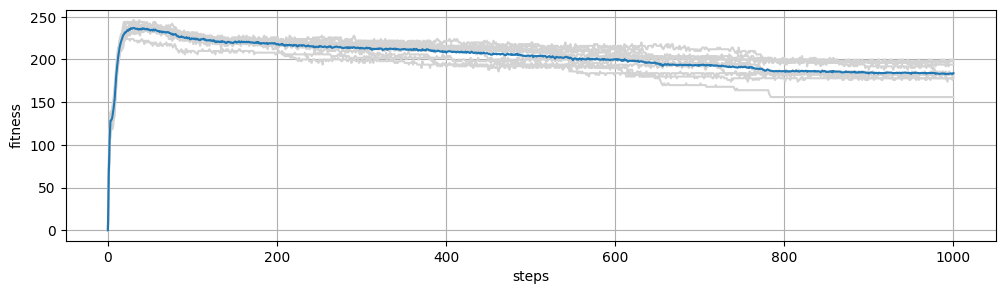

In [12]:
plt.figure(figsize=(12, 3))
plt.plot(data_trained["cumulative_reward"].T, color="lightgray")
plt.plot(data_trained["cumulative_reward"].mean(axis=0))
plt.ylabel("fitness")
plt.xlabel("steps")
plt.grid()

### Long-Term Behavior with _Competency-Decay_

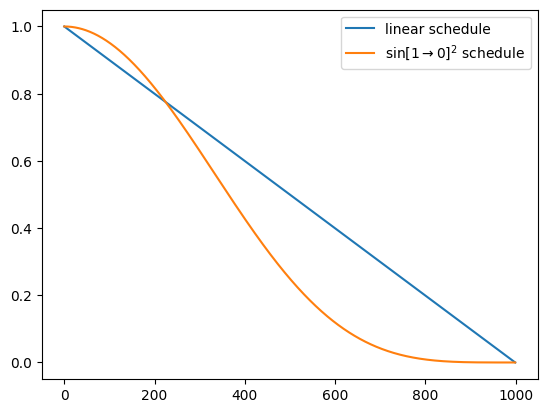

In [13]:
competency_schedule = np.linspace(1, 0, max_steps)
competency_sine_schedule = (np.sin(np.linspace(1, 0, max_steps) * np.pi * 0.5)**4)
plt.plot(competency_schedule, label='linear schedule')
plt.plot(competency_sine_schedule, label='$\\sin[1\\rightarrow0]^2$ schedule')
plt.legend();

#### Linear Schedule

In [14]:
data_competency_schedule = rollout_lifetime(world_config=world_path,
                                            competency_schedule=competency_schedule,  # the other schedules default to None
                                            noise_schedule=noise_level,
                                            num_episodes=num_episodes, max_steps=max_steps,
                                            verbose=False, render=False,
                                            **logging
                                            )

In [15]:
save_data(data_competency_schedule, filename=os.path.join(aging_path, "competency-schedule.h5"))

saved to 'data/aging/schedule/smiley_16x16/competency-schedule.h5'


In [16]:
data_competency_schedule = load_data(filename=os.path.join(aging_path, "competency-schedule.h5"))

loading from 'data/aging/schedule/smiley_16x16/competency-schedule.h5'
node: 'action', shape: (10, 1001, 16, 16, 4)
node: 'competency_schedule', shape: (1000,)
node: 'cumulative_reward', shape: (10, 1001)
node: 'embedding', shape: (10, 1001, 16, 16, 8)
node: 'noise_schedule', shape: ()
node: 'reward', shape: (10, 1001)
node: 'state', shape: (10, 1001, 16, 16, 4)
node: 'type', shape: (10, 1001, 16, 16)


#### Sine Schedule

In [17]:
data_competency_sine_schedule = rollout_lifetime(world_config=world_path,
                                                 competency_schedule=competency_sine_schedule,  # the other schedules default to None
                                                 noise_schedule=noise_level,
                                                 num_episodes=num_episodes, max_steps=max_steps,
                                                 verbose=False, render=False,
                                                 **logging
                                                 )

In [18]:
save_data(data_competency_sine_schedule, filename=os.path.join(aging_path, "competency-sine-schedule.h5"))

saved to 'data/aging/schedule/smiley_16x16/competency-sine-schedule.h5'


In [19]:
data_competency_sine_schedule = load_data(filename=os.path.join(aging_path, "competency-sine-schedule.h5"))

loading from 'data/aging/schedule/smiley_16x16/competency-sine-schedule.h5'
node: 'action', shape: (10, 1001, 16, 16, 4)
node: 'competency_schedule', shape: (1000,)
node: 'cumulative_reward', shape: (10, 1001)
node: 'embedding', shape: (10, 1001, 16, 16, 8)
node: 'noise_schedule', shape: ()
node: 'reward', shape: (10, 1001)
node: 'state', shape: (10, 1001, 16, 16, 4)
node: 'type', shape: (10, 1001, 16, 16)


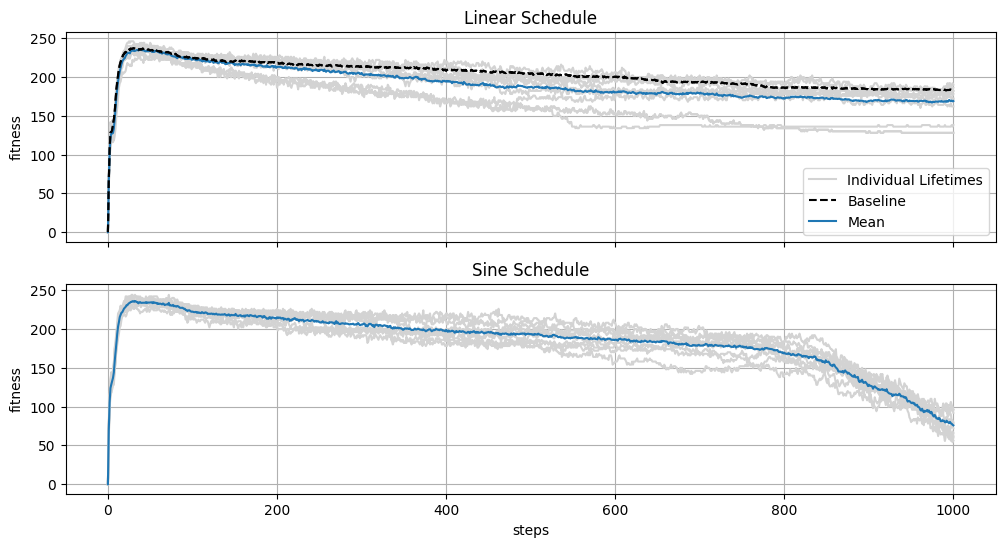

In [20]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True, sharey=True)

ax1.set_title("Linear Schedule")
ax1.plot(data_competency_schedule["cumulative_reward"].T, color="lightgray")
ax1.plot(data_competency_schedule["cumulative_reward"][0], color="lightgray", label="Individual Lifetimes")
ax1.plot(data_trained["cumulative_reward"].mean(axis=0), color="black", linestyle="--", label="Baseline")
ax1.plot(data_competency_schedule["cumulative_reward"].mean(axis=0), label="Mean")
ax1.legend()

ax2.set_title("Sine Schedule")
ax2.plot(data_competency_sine_schedule["cumulative_reward"].T, color="lightgray")
ax1.plot(data_trained["cumulative_reward"].mean(axis=0), color="black", linestyle="--")
ax2.plot(data_competency_sine_schedule["cumulative_reward"].mean(axis=0))

ax1.set_ylabel("fitness")
ax2.set_ylabel("fitness")
ax2.set_xlabel("steps")
ax1.grid()
ax2.grid()

export to data/aging/schedule/smiley_16x16/competency-schedule.pdf


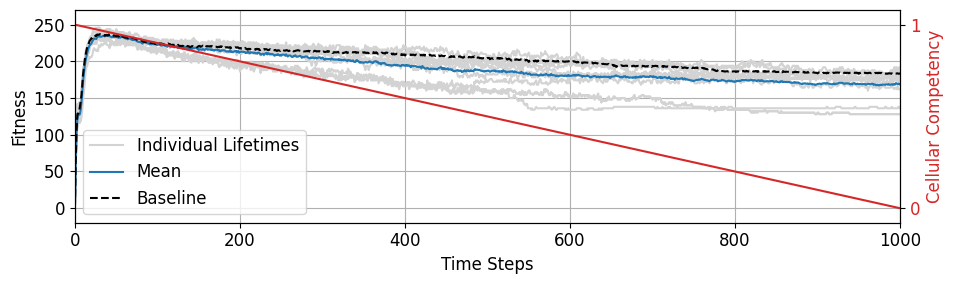

In [21]:
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

def plot_schedule(df, schedules, filename, labels = None, xlabel="Time Steps", ylabel="Fitness", ytlabel="Schedule", ylim=[-120, 270], legend=True):
    fig, ax1 = plt.subplots(1, 1, figsize=(9.7, 3.), sharex=True, sharey=True)

    ax1.plot(df["cumulative_reward"].T, color="lightgray")
    ax1.plot(df["cumulative_reward"][0], color="lightgray", label="Individual Lifetimes")
    ax1.plot(df["cumulative_reward"].mean(axis=0), label="Mean")
    ax1.plot(data_trained["cumulative_reward"].mean(axis=0), color="black", linestyle="--", label="Baseline")
    ax1.set_xlim([0, 1000])
    ax1.set_ylim(ylim)
    ax1.grid()
    ax1.set_ylabel(ylabel)
    ax1.set_xlabel(xlabel)
    
    tx1 = ax1.twinx()
    color = 'tab:red'
    print_legend = labels is not None
    if not print_legend:
        labels = [labels] * len(schedules)
    for schedule, label, c in zip(schedules, labels, ["tab:red", "tab:orange", "tab:green"]):
        data = df[schedule]
        if not data.shape:
            d = [0]
            for _ in range(1000):
                d += [d[-1] + data**2]  # variance squared
            data = np.array(d)
            print("max noise: ", data.max())
            data /= data.max()
        tx1.plot(data, color=c, label=label)
    if print_legend and legend:
        tx1.legend()
    tx1.set_ylabel(ytlabel, color=color)
    tx1.tick_params(axis='y', labelcolor=color)

    # scale right axis to grid (assome ylim is [-b-d, a+d], with a = 250 below
    a = 250
    d = ylim[1] - a
    b = -ylim[0] - d
    s = a + b + 2*d
    x = a + b
    delta = (s/x-1) * 0.5
    
    tx1.set_ylim([-delta, 1 + delta])
    tx1.set_yticks([0, 1])

    if legend:
        ax1.legend()
    plt.tight_layout()
    fig_path = os.path.join(aging_path, filename)
    print(f"export to {fig_path}")
    fig.savefig(fig_path, dpi=300)

plot_schedule(data_competency_schedule, 
              ("competency_schedule",),
              ytlabel="Cellular Competency",
              filename="competency-schedule.pdf",
              ylim=[-20, 270]
             )

export to data/aging/schedule/smiley_16x16/competency-sine-schedule.pdf


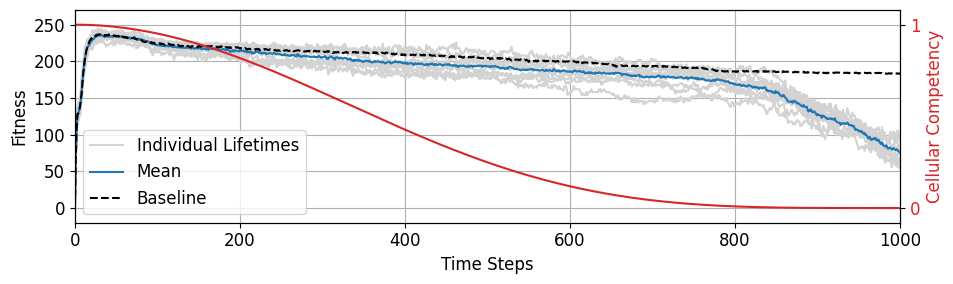

In [22]:
plot_schedule(data_competency_sine_schedule, 
              ("competency_schedule",),
              ytlabel="Cellular Competency",
              filename="competency-sine-schedule.pdf",
              ylim=[-20, 270]
             )

### Long-Term Behavior with _Increasing Action Noise Level_

In [23]:
noise_schedule = np.linspace(0., 1.0, max_steps)  # linearly scale the noise level from 0.25 (trained at) to 1

data_noise_schedule = rollout_lifetime(world_config=world_path,
                                       noise_schedule=noise_schedule,  # the other schedules default to None
                                       competency_schedule=1.,
                                       max_steps=max_steps, num_episodes=num_episodes,
                                       verbose=False, render=False,
                                       **logging
                                       )

In [24]:
save_data(data_noise_schedule, filename=os.path.join(aging_path, "noise-schedule.h5"))

saved to 'data/aging/schedule/smiley_16x16/noise-schedule.h5'


In [25]:
data_noise_schedule = load_data(filename=os.path.join(aging_path, "noise-schedule.h5"))

loading from 'data/aging/schedule/smiley_16x16/noise-schedule.h5'
node: 'action', shape: (10, 1001, 16, 16, 4)
node: 'competency_schedule', shape: ()
node: 'cumulative_reward', shape: (10, 1001)
node: 'embedding', shape: (10, 1001, 16, 16, 8)
node: 'noise_schedule', shape: (1000,)
node: 'reward', shape: (10, 1001)
node: 'state', shape: (10, 1001, 16, 16, 4)
node: 'type', shape: (10, 1001, 16, 16)


export to data/aging/schedule/smiley_16x16/noise-schedule.pdf


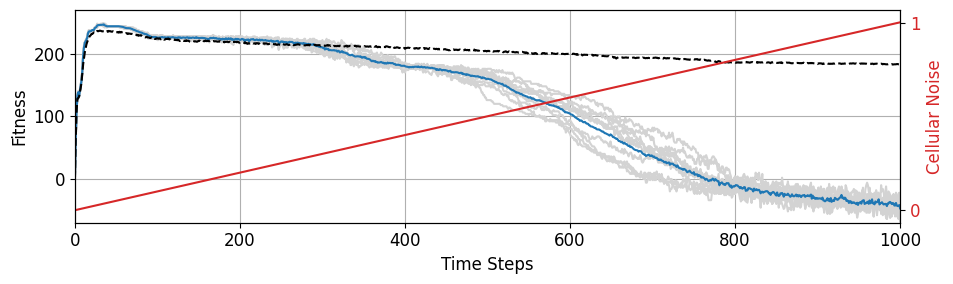

In [26]:
plot_schedule(data_noise_schedule, 
              ("noise_schedule",),
              ytlabel="Cellular Noise",
              filename="noise-schedule.pdf",
              ylim=[-70, 270],
              legend=False
             )

In [27]:
noise_schedule = np.linspace(0., 1.0, max_steps)  # linearly scale the noise level from 0.25 (trained at) to 1
competency_schedule = np.linspace(1.0, 0.0, max_steps)  # linearly scale the noise level from 0.25 (trained at) to 1

data_competency_noise_schedule = rollout_lifetime(world_config=world_path,
                                                  noise_schedule=noise_schedule,
                                                  competency_schedule=competency_schedule,
                                                  max_steps=max_steps, num_episodes=num_episodes,
                                                  verbose=False, render=False,
                                                  **logging
                                                  )

In [28]:
save_data(data_competency_noise_schedule, filename=os.path.join(aging_path, "competency-and-noise-schedule.h5"))

saved to 'data/aging/schedule/smiley_16x16/competency-and-noise-schedule.h5'


In [29]:
data_competency_noise_schedule = load_data(filename=os.path.join(aging_path, "competency-and-noise-schedule.h5"))

loading from 'data/aging/schedule/smiley_16x16/competency-and-noise-schedule.h5'
node: 'action', shape: (10, 1001, 16, 16, 4)
node: 'competency_schedule', shape: (1000,)
node: 'cumulative_reward', shape: (10, 1001)
node: 'embedding', shape: (10, 1001, 16, 16, 8)
node: 'noise_schedule', shape: (1000,)
node: 'reward', shape: (10, 1001)
node: 'state', shape: (10, 1001, 16, 16, 4)
node: 'type', shape: (10, 1001, 16, 16)


export to data/aging/schedule/smiley_16x16/competency-and-noise-schedule.pdf


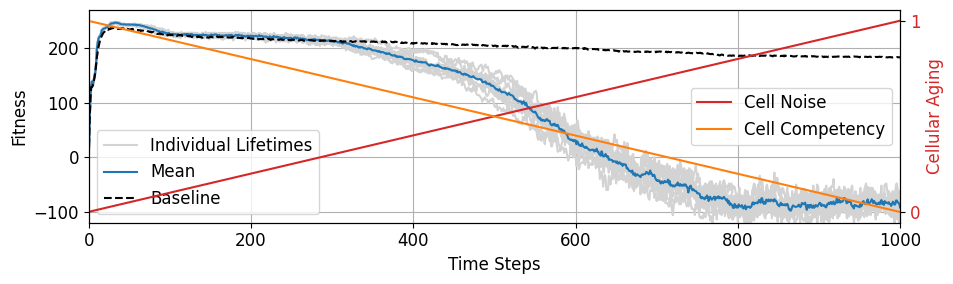

In [30]:
plot_schedule(data_competency_noise_schedule, 
              ("noise_schedule", "competency_schedule"),
              labels=("Cell Noise", "Cell Competency"),
              ytlabel="Cellular Aging",
              filename="competency-and-noise-schedule.pdf",
              ylim=[-120, 270],
              legend=True
             )

### Long-Term Behavior with _Noisy ANN Parameters_

In [31]:
ann_noise_level = 0.01  # Width auf Gaussian Noise added to the ANN parameters of (all) Agents at each time step

data_ann_schedule = rollout_lifetime(world_config=world_path,
                                     ann_schedule=ann_noise_level, 
                                     noise_schedule=noise_level,
                                     competency_schedule=1.0,
                                     max_steps=max_steps, num_episodes=num_episodes,
                                     verbose=False, render=False,
                                     **logging
                                     )

In [32]:
save_data(data_ann_schedule, filename=os.path.join(aging_path, "ann-schedule.h5"))

saved to 'data/aging/schedule/smiley_16x16/ann-schedule.h5'


In [33]:
data_ann_schedule = load_data(filename=os.path.join(aging_path, "ann-schedule.h5"))

loading from 'data/aging/schedule/smiley_16x16/ann-schedule.h5'
node: 'action', shape: (10, 1001, 16, 16, 4)
node: 'ann_schedule', shape: ()
node: 'competency_schedule', shape: ()
node: 'cumulative_reward', shape: (10, 1001)
node: 'embedding', shape: (10, 1001, 16, 16, 8)
node: 'noise_schedule', shape: ()
node: 'reward', shape: (10, 1001)
node: 'state', shape: (10, 1001, 16, 16, 4)
node: 'type', shape: (10, 1001, 16, 16)


schedule is given by std applied to ann params, thus we plot the variance (std**2) over time, as N successive gaussians of form (mu, sigma**2) is equivalent to singe gaussian with (mu, N sigma **2)

In [34]:
data_ann_schedule["ann_schedule"], data_ann_schedule["ann_schedule"].shape

(array(0.01), ())

max noise:  0.10000000000000184
export to data/aging/schedule/smiley_16x16/ann-schedule.pdf


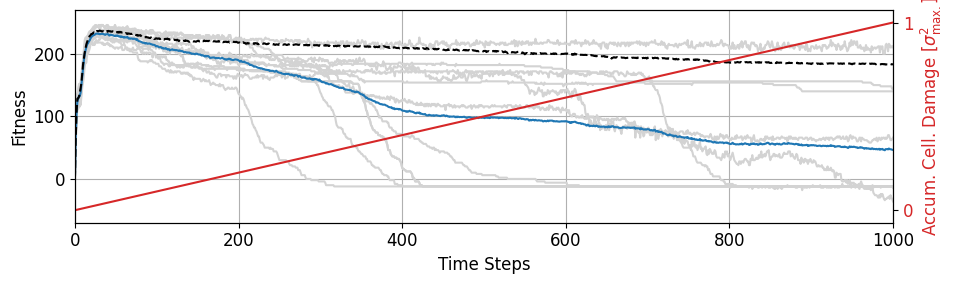

In [35]:
plot_schedule(data_ann_schedule, 
              ("ann_schedule",),
              ytlabel="Accum. Cell. Damage [$\sigma_\mathrm{max.}^2$]",
              filename="ann-schedule.pdf",
              ylim=[-70, 270],
              legend=False
             )

### Long-Term Behavior with Connectivity-Decay

In [36]:
sensitivity_schedule = np.linspace(1.0, 0.0, max_steps)  # linearly scale from "full" to "none" competency

data_sensitivity_schedule = rollout_lifetime(world_config=world_path,
                                             sensitivity_schedule=sensitivity_schedule,  # the other schedules default to None
                                             noise_schedule=noise_level,
                                             competency_schedule=1.0,
                                             num_episodes=num_episodes, max_steps=max_steps,
                                             verbose=False, render=False,
                                             **logging
                                             )

In [37]:
save_data(data_sensitivity_schedule, filename=os.path.join(aging_path, "connectivity-schedule.h5"))

saved to 'data/aging/schedule/smiley_16x16/connectivity-schedule.h5'


In [38]:
data_sensitivity_schedule = load_data(filename=os.path.join(aging_path, "connectivity-schedule.h5"))

loading from 'data/aging/schedule/smiley_16x16/connectivity-schedule.h5'
node: 'action', shape: (10, 1001, 16, 16, 4)
node: 'competency_schedule', shape: ()
node: 'cumulative_reward', shape: (10, 1001)
node: 'embedding', shape: (10, 1001, 16, 16, 8)
node: 'noise_schedule', shape: ()
node: 'reward', shape: (10, 1001)
node: 'sensitivity_schedule', shape: (1000,)
node: 'state', shape: (10, 1001, 16, 16, 4)
node: 'type', shape: (10, 1001, 16, 16)


export to data/aging/schedule/smiley_16x16/connectivity-schedule.pdf


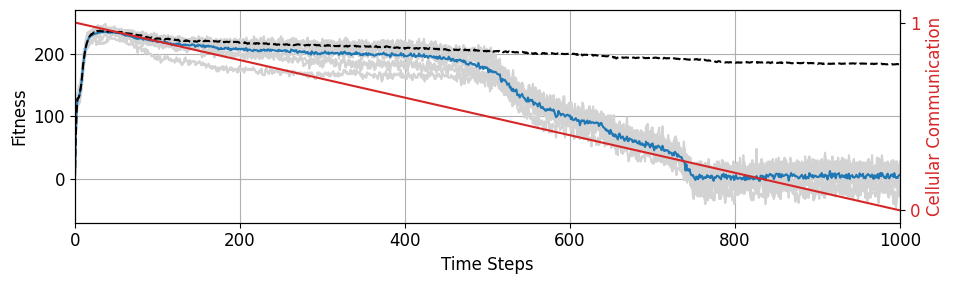

In [39]:
plot_schedule(data_sensitivity_schedule, 
              ("sensitivity_schedule",),
              ytlabel="Cellular Communication",
              filename="connectivity-schedule.pdf",
              ylim=[-70, 270],
              legend=False
             )